In [1]:
#|default_exp comparison_space
## Standard libraries
import os
import math
import numpy as np
import time
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## project specifics
import diffusion_curvature
import jax
import jax.numpy as jnp
jax.devices()


/tmp/ipykernel_245091/4082863432.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


[gpu(id=0)]

# Comparison Space Construction
> Making graphs flat

The construction of the comparison space is the most delicate operation diffusion curvature performs. The key to our construction is ensuring that diffusion, at a single scale, behaves equivalently on the manifold and the graph. Recall our connections to Ollivier's theory: we just need to ensure that the *jump* of diffusion is the same in both spaces. Curvature emerges from the interactions of diffusion at higher timesteps.

Our comparisons take pure graphs as input. We don't change the euclidean comparison space (which we sample uniformly from an nd random distribution). Instead, we tune the parameters of the kernel to minimize the KLD between the target jump and the average jump in our (boundary-excluded) comparison space. Thus, the beating heart of this approach is the differentiable graph constructor which is expressive enough to approximate a wide variety of graphs).

The most contentious point of this implementation is how to compute the $W_1$ distances. We need a metric for each of the graphs; but how is this to be constructed, given that the graph itself is in flux? We have the geodesic distances for the sampled euclidean points, but those won't be on the same scale as whatever graph distance we use on the manifold.

Our solution is to use PHATE distances with $t=1$. This requires only taking the log of the diffusion matrix, and for a single scale of distances is basically a way of converting affinities back into distances.

In [2]:
from diffusion_curvature.graphs import generic_kernel, diffusion_matrix_from_affinities
from diffusion_curvature.distances import phate_distances_differentiable, pairwise_euclidean
from diffusion_curvature.utils import random_jnparray
from diffusion_curvature.diffusion_laziness import wasserstein_spread_of_diffusion
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax

class EuclideanComparisonSpace(nn.Module):
    dimension:int  # dimension of comparison space
    num_points:int # num points to sample; best determined as a subset of the number of points in your manifold.
    jump_of_diffusion:jax.Array # the W1 distance from a single step of diffusion (t=1) to its origin
    fraction_of_points:float = 0.8

    def setup(self):
        # compute optimal number of points given dimension
        self.Rn = jnp.concatenate([jnp.zeros((1,self.dimension)), 2*random_jnparray(self.num_points-1, self.dimension)-1])
        self.num_useful_points = int(self.fraction_of_points * self.num_points)
        # Sort values by distance to center point (i.e. the origin)
        distances_to_center = (self.Rn**2).sum(-1)
        sorting_idxs = jnp.argsort(distances_to_center)
        self.Rn = self.Rn[sorting_idxs]
        # precompute distances for kernel
        self.D = pairwise_euclidean(self.Rn,self.Rn)
        # initialize tunable parameters
        sigma_base = nn.initializers.constant(0.7)
        self.sigma = self.param(
            'kernel bandwidth',
            sigma_base, # Initial value of kernel bandwidth
            1 # size - it's just one value.
        )
        anisotropy_base = nn.initializers.constant(0.5)
        self.anisotropic_density_normalization = self.param(
            'anisotropic normalization',
            anisotropy_base, # Initial value of kernel bandwidth
            1 # size - it's just one value.
        )

    def __call__(self):
        A = generic_kernel(self.D, self.sigma, self.anisotropic_density_normalization)
        P = diffusion_matrix_from_affinities(A)
        # D_manifold = phate_distances_differentiable(P)
        W1 = wasserstein_spread_of_diffusion(self.D,P) # vector of all W1 values in comparison space.
        # discard edge values; take only top 80% of W1s, corresponding to closest 80% of values.
        # TODO: 80% is arbitrary and could be improved.
        W1s_close_to_center = W1[:-self.num_useful_points]
        return {
            'mean jump difference':jnp.mean(W1s_close_to_center) - self.jump_of_diffusion, 
            'A':A, 
            'P':P, 
            'D':self.D
        }

In [3]:
# import jax.random as random
# model = EuclideanComparisonSpace(dimension=2, num_points=1000, jump_of_diffusion=0.47)
# key1, key2 = jax.random.split(jax.random.key(0))
# params = model.init(key2)

In [8]:
#|export
import optax
import jax.random as random
def fit_comparison_space_model(model, max_epochs = 1000, verbose=False):
    def train_comparison_space_model(params):
        out_dict = model.apply(params)
        return out_dict['mean jump difference']
    key1, key2 = jax.random.split(jax.random.key(0))
    params = model.init(key2)
    tx = optax.adam(learning_rate=1e-3)
    opt_state = tx.init(params)
    loss_grad_fn = jax.value_and_grad(train_comparison_space_model)
    for i in range(max_epochs):
        loss_val, grads = loss_grad_fn(params)
        if loss_val < 1e-5: break
        updates, opt_state = tx.update(grads,opt_state)
        params = optax.apply_updates(params,updates)
    if verbose: print("ending with loss value", loss_val)
    return params

Here's an example of instantiating and fitting a comparison space.

In [9]:
model = EuclideanComparisonSpace(dimension=2, num_points=1000, jump_of_diffusion=0.47)
params = fit_comparison_space_model(model, max_epochs=1000)
euclidean_stuffs = model.apply(params) # dictionary containing A, P, D

In [11]:
from diffusion_curvature.diffusion_laziness import wasserstein_spread_of_diffusion
P_euclidean = euclidean_stuffs['P']
D_euclidean = euclidean_stuffs['D']
wass_spreads = wasserstein_spread_of_diffusion(D_euclidean, P_euclidean)

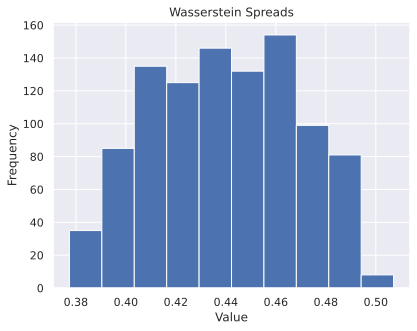

In [14]:
import matplotlib.pyplot as plt
import numpy as np
# Plot histogram
plt.hist(wass_spreads, bins=10)  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Wasserstein Spreads')
plt.grid(True)

# Display the plot
plt.show()


The fitting has worked, adjusting the kernel until our imaginary wasserstein spread value is achieved pretty uniformly.

# Pointcloud Construction

In [7]:
#|export
import pygsp
import numpy as np

def euclidean_comparison_graph(G:pygsp.graphs.Graph, dimension):
        """
        Constructs a flat graph, hewn from uniform random noise of the supplied dimension.
        Calculates the powered diffusion matrix on this graph.
        """
        noise = np.concatenate([np.zeros((1,dimension)), 2*np.random.rand(G.K.shape[0]-1,dimension)-1])
        # Build a graph out of the noise, with all of the same kernel settings as our first graph
        # NOTE: The graph building settings must be scale invariant! 
        params = G.get_params()
        needed_keys = ['data', 'n_pca', 'knn', 'decay', 'bandwidth', 'bandwidth_scale', 
                    'knn_max', 'anisotropy', 'beta', 'adaptive_k', 'n_landmark', 'n_landmark', 
                    'n_svd', 'n_jobs']
        found_keys = {} # TODO: Likely a more elegant way to do this
        for nk in needed_keys:
            if nk in params.keys():
                found_keys[nk] = params[nk]
            else:
                found_keys[nk] = None
        
        G_flat = graphtools.Graph(
            data = noise,
            n_pca = found_keys['n_pca'],
            knn = found_keys['knn'],
            decay = found_keys['decay'],
            bandwidth = found_keys['bandwidth'],
            bandwidth_scale = found_keys['bandwidth_scale'],
            knn_max = found_keys['knn_max'],
            anisotropy = found_keys['anisotropy'],
            beta = found_keys['beta'],
            adaptive_k = found_keys['adaptive_k'],
            n_landmark = found_keys['n_landmark'],
            n_svd = found_keys['n_svd'],
            n_jobs = found_keys['n_jobs'],
            graphtype = get_graph_type(G),
        )
        return G_flat